In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, StratifiedKFold

from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import seaborn as sns

import modelEvalUtils as meu

from feature_importance import FeatureImportance


# %config InlineBackend.figure_formats = ['svg']
%matplotlib inline

plt.rcParams['figure.figsize'] = (9, 6)
sns.set(context='notebook', style='whitegrid', font_scale=1.2)

In [2]:
base_df = pd.read_csv("../Data/clinvar_conflicting.csv", dtype={"CHROM": "string", "MOTIF_NAME": "string", "HIGH_INF_POS": "string"})

In [3]:
base_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65188 entries, 0 to 65187
Data columns (total 46 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   CHROM               65188 non-null  string 
 1   POS                 65188 non-null  int64  
 2   REF                 65188 non-null  object 
 3   ALT                 65188 non-null  object 
 4   AF_ESP              65188 non-null  float64
 5   AF_EXAC             65188 non-null  float64
 6   AF_TGP              65188 non-null  float64
 7   CLNDISDB            65188 non-null  object 
 8   CLNDISDBINCL        167 non-null    object 
 9   CLNDN               65188 non-null  object 
 10  CLNDNINCL           167 non-null    object 
 11  CLNHGVS             65188 non-null  object 
 12  CLNSIGINCL          167 non-null    object 
 13  CLNVC               65188 non-null  object 
 14  CLNVI               27659 non-null  object 
 15  MC                  64342 non-null  object 
 16  ORIG

In [4]:
# reduce the data frame and do some basic cleaning, start with just a few bare features

# features to test first:
#     - CHROM, REF, ALT, AF_*, CLNVC, ORIGIN, CLASS, Allele, Consequence, IMPACT, STRAND

# features which don't seem to be super useful (maybe they would be when all together)
# CHROM, REF, ALT, CLNVC, ORIGIN, Consequence, IMPACT (seems like this should be at a least a little useful), STRAND

# select features

target_var = ['CLASS']
# other_features = ['CHROM']
# categorical_features = ['REF', 'ALT']
other_features = []
# categorical_features = ['CHROM', 'REF', 'ALT']
# numeric_features = ['CADD_PHRED']



# best so far:
categorical_features = ['CLNVC', 'IMPACT', 'SYMBOL'] #, 'MC', 'Feature', 'SIFT', 'PolyPhen']
numeric_features = ['CADD_PHRED', 'STRAND', 'AF_TGP', 'LoFtool'] #, 'AF_ESP', 'AF_EXAC', 'POS', 'EXON']

# reduced_df = base_df[['CLASS', 'CHROM', 'REF', 'ALT', 'CLNVC', 'ORIGIN', 'Consequence', 'IMPACT', 'STRAND']]

# 'Consequence',
#

reduced_df = base_df[target_var + other_features + categorical_features + numeric_features]

# feature cleaing/adjustment below here

# replace nulls
# reduced_df["SIFT"].fillna("SIFT_UNKNOWN", inplace = True)
# reduced_df["PolyPhen"].fillna("unknown", inplace = True)

# drop nulls
reduced_df.dropna(inplace=True)

# CHROM - turn CHROM strings into numbers
# reduced_df.loc[reduced_df['CHROM'] == 'X', 'CHROM'] = '23'
# reduced_df.loc[reduced_df['CHROM'] == 'MT', 'CHROM'] = '24'
# reduced_df["CHROM"] = pd.to_numeric(reduced_df["CHROM"])

    # dropping MT rows (after it was converted to 24)
    # reduced_df.drop(reduced_df[reduced_df['CHROM'] == 24].index, inplace=True)

# REF, ALT - lots of alleles with more than one type, combine them all as "2+" instead of dropping them like below
# reduced_df.loc[reduced_df['REF'].str.len() > 1, 'REF'] = '2+'
# reduced_df.loc[reduced_df['ALT'].str.len() > 1, 'ALT'] = '2+'


# ORIGIN - combine ORIGIN values if they are more than 1 (too many of them, and they are a sum of the smaller parts, making it difficult to split them out - could try and do that though)
# reduced_df['ORIGIN'] = reduced_df['ORIGIN'].astype(str)
# reduced_df.loc[reduced_df['ORIGIN'] != '1', 'ORIGIN'] = '1+'
    # try dropping most common one to see if there are any trends for the lesser count categories
    # reduced_df.drop(reduced_df[reduced_df['ORIGIN'] == 1].index, inplace=True)

# Consequence - drop those with less than 100 counts
# consequence_counts = reduced_df['Consequence'].value_counts()
# reduced_df['Consequence'] = np.where(reduced_df['Consequence'].isin(consequence_counts.index[consequence_counts >= 100]), reduced_df['Consequence'], 'OTHER_CONSQ')


# MC - drop those with less than 100 counts
# reduced_df = reduced_df.groupby('MC').filter(lambda x : len(x)>100)

# SYMBOL - combine those with less than 100 counts
symbol_counts = reduced_df['SYMBOL'].value_counts()
reduced_df['SYMBOL'] = np.where(reduced_df['SYMBOL'].isin(symbol_counts.index[symbol_counts >= 100]), reduced_df['SYMBOL'], 'OTHER')

# Feature - combine those with less than 100 counts
# feature_counts = reduced_df['Feature'].value_counts()
# reduced_df['Feature'] = np.where(reduced_df['Feature'].isin(feature_counts.index[feature_counts >= 100]), reduced_df['Feature'], 'OTHER_Feature')


# EXON
# reduced_df['EXON'] = reduced_df['EXON'].apply(lambda L: (float(L.split("/",1)[0]) / float(L.split("/",1)[1])) )


# print(reduced_df['CLASS'].unique())
# print(reduced_df['CLASS'].value_counts())

reduced_df.info()

<ipython-input-4-8aa9bad74789>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_df.dropna(inplace=True)
<ipython-input-4-8aa9bad74789>:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reduced_df['SYMBOL'] = np.where(reduced_df['SYMBOL'].isin(symbol_counts.index[symbol_counts >= 100]), reduced_df['SYMBOL'], 'OTHER')


<class 'pandas.core.frame.DataFrame'>
Int64Index: 59945 entries, 6 to 65187
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CLASS       59945 non-null  int64  
 1   CLNVC       59945 non-null  object 
 2   IMPACT      59945 non-null  object 
 3   SYMBOL      59945 non-null  object 
 4   CADD_PHRED  59945 non-null  float64
 5   STRAND      59945 non-null  float64
 6   AF_TGP      59945 non-null  float64
 7   LoFtool     59945 non-null  float64
dtypes: float64(4), int64(1), object(3)
memory usage: 4.1+ MB


In [5]:
# check categorical variables vs conflicting or not to try and find some predictive features - do this before encoding so there are less plots to make
# for col in reduced_df.columns:
#     if(col == 'CLASS' or col == 'CADD_PHRED'): continue
#     plt.figure()
#     counts = (reduced_df.groupby(['CLASS'])[col]
#                      .value_counts(normalize=True)
#                      .rename('percentage')
#                      .mul(100)
#                      .reset_index()
#                      .sort_values(col))
#     sns.barplot(x=col, y="percentage", hue="CLASS", data=counts)


In [6]:
# sns.scatterplot(df_train, corner=True, height=1.5, plot_kws={'size': 3}, hue='CLASS');

In [7]:
# columns_to_encode = list(reduced_df.columns)
# columns_to_encode.remove('CLASS')
# columns_to_encode.remove('CHROM')
# columns_to_encode.remove('CADD_PHRED')
# columns_to_encode

In [8]:
# encode REF column 
# encoded_df = pd.get_dummies(reduced_df, prefix=['CHROM', 'REF', 'ALT', test_var], columns=['CHROM', 'REF', 'ALT', test_var])
# encoded_df = pd.get_dummies(reduced_df, prefix=['REF', 'ALT', 'CLNVC', 'ORIGIN', 'Consequence'], columns=['REF', 'ALT', 'CLNVC', 'ORIGIN', 'Consequence'])
# encoded_df = pd.get_dummies(reduced_df, prefix=['REF', 'ALT', 'Consequence', test_var], columns=['REF', 'ALT', 'Consequence', test_var])
# encoded_df = pd.get_dummies(reduced_df, prefix=['REF', 'ALT', test_var], columns=['REF', 'ALT', test_var])
# encoded_df = pd.get_dummies(reduced_df, prefix=columns_to_encode, columns=columns_to_encode)
# encoded_df

In [9]:
# split data into test and train sets
# df_train, df_test = train_test_split(reduced_df, test_size=0.2, random_state=55)
# df_train, df_test = train_test_split(encoded_df, test_size=0.2, random_state=55)

In [10]:
# sns.pairplot(df_train, corner=True, height=1.5, plot_kws={'size': 3}, hue='CLASS');

In [11]:
# sns.kdeplot(df_train['CHROM'], hue=df_train['CLASS'])
# sns.kdeplot(df_train.loc[df_train['CLASS'] == 0, 'CHROM'], color='r')
# sns.kdeplot(df_train.loc[df_train['CLASS'] == 1, 'CHROM'], color='b')

In [12]:
# sns.countplot(df_train.loc[df_train['CLASS'] == 0, 'CHROM'], color='r')
# sns.countplot(df_train.loc[df_train['CLASS'] == 1, 'CHROM'], color='b')

In [13]:
# stop

In [14]:
# split out features and target for models

feature_data = reduced_df.drop('CLASS', axis=1)
target_data = reduced_df['CLASS']

feature_data.reset_index(inplace=True, drop=True)
target_data.reset_index(inplace=True, drop=True)

X_train, X_test, y_train, y_test = train_test_split(feature_data, target_data, test_size=0.2, random_state=55)


In [15]:
# print(y_train.value_counts(normalize=True))
# print(y_test.value_counts(normalize=True))

In [16]:

numeric_transformer = StandardScaler()
fake_transformer = StandardScaler(with_mean=False, with_std=False) # the class I'm using to print feature importance will drop those columns which don't get transformer, so just put a fake one in which does nothing

# categorical_transformer = OneHotEncoder(handle_unknown='ignore')
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse=False)

kNN_preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)], 
    remainder='passthrough')

tree_preprocessor = ColumnTransformer(
    transformers=[
        ('num', fake_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)],
    remainder='passthrough')


In [17]:
# various models
dummy_model = DummyClassifier(strategy="most_frequent")
# knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model = KNeighborsClassifier(n_neighbors=20)


dt_model = DecisionTreeClassifier(max_depth=25, max_features=20, random_state=121)
# rf_model = RandomForestClassifier(n_estimators=10, random_state=121)
rf_model = RandomForestClassifier(n_estimators=10, max_depth=25, max_features=20, random_state=121)

# {'classifier__max_depth': 25, 'classifier__max_features': 20, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 10}

# gb_model = xgb.XGBClassifier( 
#             n_estimators=30000,
#             max_depth=4,
#             objective='binary:logistic', #new objective
#             use_label_encoder=False,
#             learning_rate=.05, 
#             subsample=.8,
#             min_child_weight=3,
#             colsample_bytree=.8)
            

base_models = ["dummy_model"]#"knn_model"] # "dummy_model",
# tree_models = ["rf_model"]#, "gb_model"] "dt_model", 
tree_models = []#"dt_model"]#, "gb_model"]

Current model is:  dummy_model
Cross validation scores:
 [0. 0. 0. 0. 0.]


/Users/NickPC/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.75      1.00      0.86     35810
           1       0.00      0.00      0.00     12146

    accuracy                           0.75     47956
   macro avg       0.37      0.50      0.43     47956
weighted avg       0.56      0.75      0.64     47956

[0.25 1.35] [Text(0, 0.25, 'non-conflicting'), Text(0, 1.35, 'conflicting')]


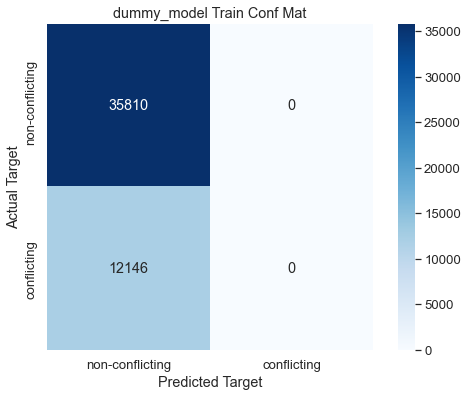

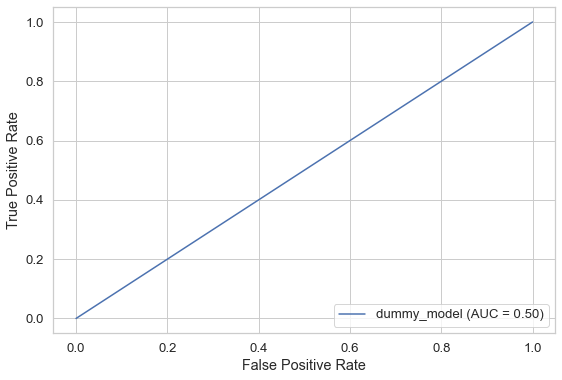

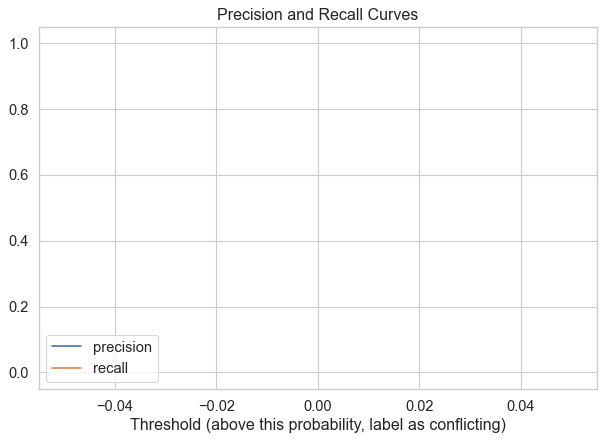

/Users/NickPC/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.75      1.00      0.85      8948
           1       0.00      0.00      0.00      3041

    accuracy                           0.75     11989
   macro avg       0.37      0.50      0.43     11989
weighted avg       0.56      0.75      0.64     11989

[0.25 1.35] [Text(0, 0.25, 'non-conflicting'), Text(0, 1.35, 'conflicting')]


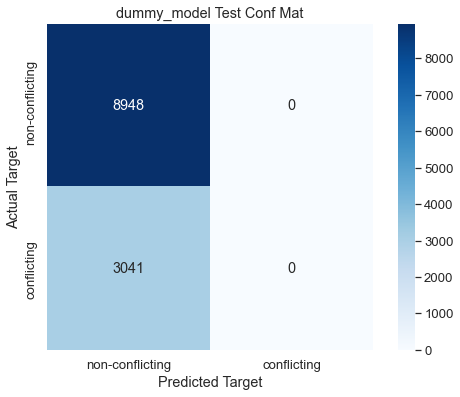

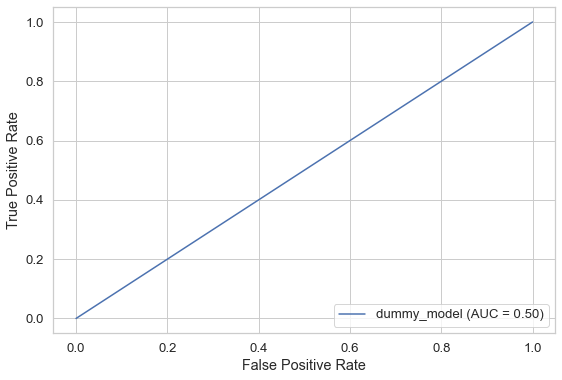

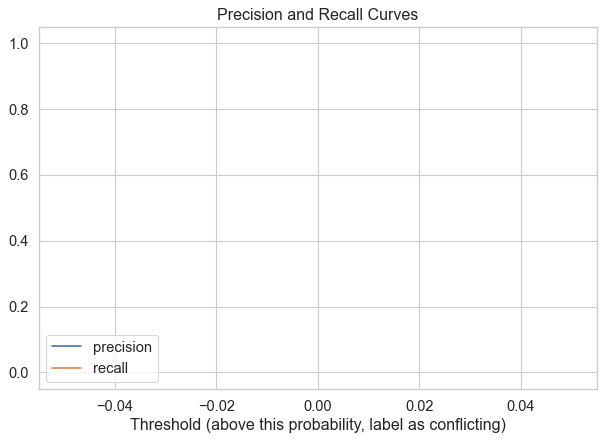

In [18]:
# run over base models
for model_name in base_models:
    print('Current model is: ', model_name)

    kNN_pipeline = Pipeline(steps=[('kNN_preprocessor', kNN_preprocessor),
                                   ('classifier', eval(model_name))])
    
    scores = cross_validate(kNN_pipeline, X_train, y_train,
#                          scoring='f1_macro',
                         scoring='recall',
                         return_estimator=True)
    
    print('Cross validation scores:\n', scores['test_score'])
    
    kNN_pipeline.fit(X_train, y_train)
    y_pred = kNN_pipeline.predict(X_train)
    meu.printMetricsAndConfMat(y_train, y_pred, model_name + " Train")
    
    meu.makeMetricPlots(kNN_pipeline, X_train, y_train, model_name)

#     feature_importance = FeatureImportance(kNN_pipeline)
#     feature_importance.plot(height=800, top_n_features=25)
    
#     y_test_pred = kNN_pipeline.predict(X_test)
#     meu.printMetricsAndConfMat(y_test, y_test_pred, model_name + " Test")
    
    y_test_pred = meu.adjusted_classes(kNN_pipeline.predict_proba(X_test)[:,1], 0.3)
    
    meu.printMetricsAndConfMat(y_test, y_test_pred, model_name + " Test")
    meu.makeMetricPlots(kNN_pipeline, X_test, y_test, model_name)

In [19]:
# run over tree models
for model_name in tree_models:
    print('Current model is: ', model_name)

    tree_pipeline = Pipeline(steps=[('tree_preprocessor', tree_preprocessor),
                                    ('classifier', eval(model_name))])  
            
    scores = cross_validate(tree_pipeline, X_train, y_train,
#                          scoring='f1_weighted',
                         scoring='recall',
                         return_estimator=True,
                         n_jobs=-1)
    
    print('Cross validation scores:\n', scores['test_score'])        
        
    tree_pipeline.fit(X_train, y_train)
    y_pred = tree_pipeline.predict(X_train)
    meu.printMetricsAndConfMat(y_train, y_pred, model_name + " Train")
    
    meu.makeMetricPlots(tree_pipeline, X_train, y_train, model_name)

    
#     print('\n', 'Feature importance check: ', tree_pipeline.steps[1][1].feature_importances_.shape, '\n')
#     print('\n', 'Feature importance check: ', tree_pipeline.steps[1][1].get_feature_names().shape, '\n')

    feature_importance = FeatureImportance(tree_pipeline)
    feature_importance.plot(height=800, top_n_features=25)
    
    
#     def plot(self, top_n_features=100, rank_features=True, max_scale=True, 
#              display_imp_values=True, display_imp_value_decimals=1,
#              height_per_feature=25, orientation='h', width=750, height=None, 
#              str_pad_width=15, yaxes_tickfont_family='Courier New', 
#              yaxes_tickfont_size=15):
    

#     y_test_pred = tree_pipeline.predict(X_test) # equivalent to the line below with a threshold of 0.5
    y_test_pred = meu.adjusted_classes(tree_pipeline.predict_proba(X_test)[:,1], 0.3)
    
    
    meu.printMetricsAndConfMat(y_test, y_test_pred, model_name + " Test")
    meu.makeMetricPlots(tree_pipeline, X_test, y_test, model_name)
    

In [20]:
raise SystemExit("Stop right there!")

SystemExit: Stop right there!

/Users/NickPC/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3426: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
# grid search cv instead of cross_validate

# param_grid = {
#     'classifier__min_samples_split': [3, 4, 5, 10], 
#     'classifier__n_estimators' : [10, 100, 300],
#     'classifier__max_depth': [3, 5, 15, 25],
#     'classifier__max_features': [3, 5, 10, 20]
# }

param_grid = {
    'classifier__min_samples_split': [2, 5, 10], 
    'classifier__n_estimators' : [10],
    'classifier__max_depth': [3, 5, 15, 25],
    'classifier__max_features': [3, 5, 10, 20]
}

# dt_model = DecisionTreeClassifier(max_depth=4, random_state=121)
# rf_model = RandomForestClassifier(n_estimators=10, random_state=121)

# scorers = {
#     'precision_score': make_scorer(precision_score),
#     'recall_score': make_scorer(recall_score),
#     'accuracy_score': make_scorer(accuracy_score)
# }

rf_model_gridsearch = RandomForestClassifier(n_jobs=-1, random_state=121)

tree_pipeline_gridsearch = Pipeline(steps=[('tree_preprocessor', tree_preprocessor),
                                ('classifier', rf_model_gridsearch)])  


skf = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(tree_pipeline_gridsearch, param_grid, scoring='recall', refit='recall',
                       cv=skf, return_train_score=True, n_jobs=-1)

grid_search.fit(X_train, y_train)

print('Best params for {}'.format('recall'))
print(grid_search.best_params_)


# make the predictions
y_pred = grid_search.predict(X_train)

meu.printMetricsAndConfMat(y_train, y_pred, "GridSearch RF Train")
meu.makeMetricPlots(grid_search, X_train, y_train, "GridSearch RF")


# feature_importance = FeatureImportance(grid_search)
# feature_importance = FeatureImportance(tree_pipeline_gridsearch)
# feature_importance.plot(height=800, top_n_features=25)

y_test_pred = meu.adjusted_classes(grid_search.predict_proba(X_test)[:,1], 0.5)

meu.printMetricsAndConfMat(y_test, y_test_pred, "GridSearch RF Train")
meu.makeMetricPlots(grid_search, X_test, y_test, "GridSearch RF")
    
    
    
    
    # confusion matrix on the test data.
#     print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
#     print(pd.DataFrame(confusion_matrix(y_test, y_pred),
#                  columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
#     return grid_search





In [ ]:
y_test_pred = meu.adjusted_classes(grid_search.predict_proba(X_test)[:,1], 0.3)

meu.printMetricsAndConfMat(y_test, y_test_pred, "GridSearch RF Train")
# meu.makeMetricPlots(grid_search, X_test, y_test, "GridSearch RF")
 

In [ ]:
# from sklearn.base import BaseEstimator, TransformerMixin

# class DFChecker(BaseEstimator, TransformerMixin):
#     def __init__(self, numberCheck):
#         print('Calling init!', numberCheck, ' \n')
#         self.numberCheck = numberCheck
        
#     def fit(self, x, y = None):
#         print('Calling fit!', self.numberCheck, ' \n')
        
#         print(x.shape)
#         if(self.numberCheck == 1):
#             print(x.iloc[0])
#         else:
#             print(x[0])
        
#         return self
    
#     def transform(self, x, y = None):
#         print('Calling transform!', self.numberCheck, ' \n')
#         x_ = x.copy()
        
#         print(x_.shape)
#         if(self.numberCheck == 1):
#             print(x_.iloc[0])
#         else:
#             print(x_[0])
            
#         return x_